                          🐶Classification of Pet Facial Expression Images😸

**Note: This program contains a large number of pet photos.**

**Import**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import drive
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import random
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import shutil
import random
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Define dataset name and dataset path**

In [ ]:
# Load Train Data.
train_AngryData = '/content/drive/MyDrive/437/archive/Master Folder/train/Angry'
train_SadData = '/content/drive/MyDrive/437/archive/Master Folder/train/Sad'
train_HappyData = '/content/drive/MyDrive/437/archive/Master Folder/train/happy'
train_OtherData = '/content/drive/MyDrive/437/archive/Master Folder/train/Other'
train_data = '/content/drive/MyDrive/437/archive/Master Folder/train'
valid_data = '/content/drive/MyDrive/437/archive/Master Folder/valid'
test_data = '/content/drive/MyDrive/437/archive/Master Folder/test'

**Test image load**

In [ ]:
# Print the first photo of each document to test reading the file correctly.
def testImage(directory):
  # Check if the directory exists
  if os.path.isdir(directory):
    # Read the first file
    read_file = os.listdir(directory)[0]
    # Read the first image path
    image_path = os.path.join(directory, read_file)
    # Display the Image
    pet_image = mpimg.imread(image_path)
    plt.imshow(pet_image)
    plt.title(f"{os.path.basename(directory)}")
    plt.show()

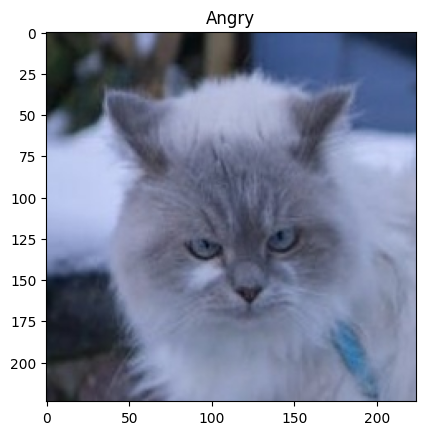

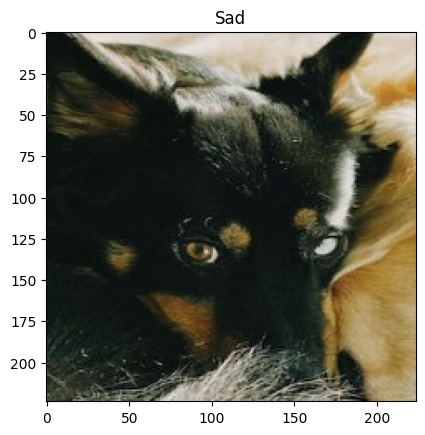

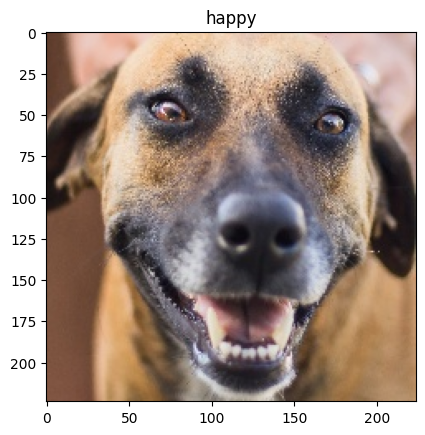

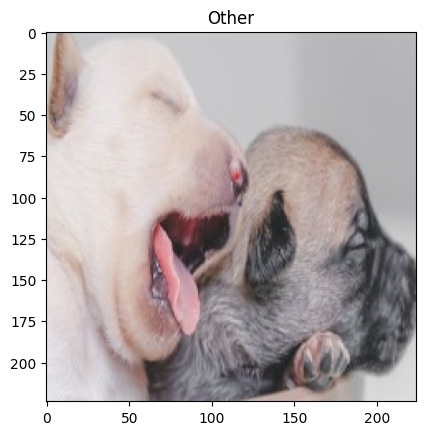

In [ ]:
# Print for test Angry.
testImage(train_AngryData)

# Print for test Sad.
testImage(train_SadData)

# Print for test Happy.
testImage(train_HappyData)

# Print for test Other.
testImage(train_OtherData)

**Calculate the number of each class in the dataset to ensure that the data set is balanced**

In [ ]:
# Processes image data and standardizes their size and specifications.
# normalization_size = ImageDataGenerator(rescale = 1./255)

# normalization_train = normalization_size.flow_from_directory(train_data, target_size = (224, 224), batch_size = 16, class_mode='binary')

Image in /content/drive/MyDrive/437/archive/Master Folder/train/Angry
Target size is : (224, 224), Batch size is : 32


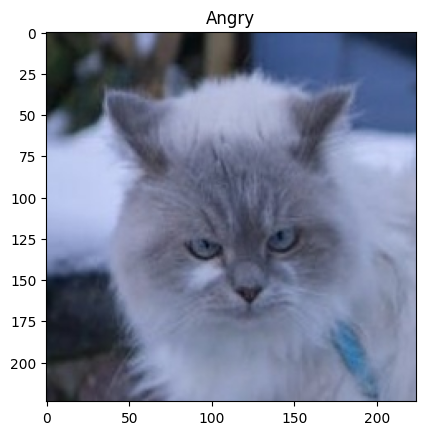

Image in /content/drive/MyDrive/437/archive/Master Folder/train/Sad
Target size is : (224, 224), Batch size is : 32


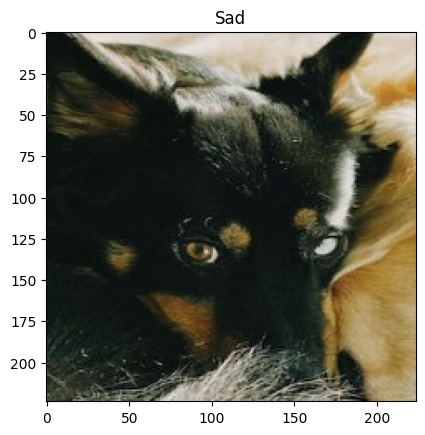

Image in /content/drive/MyDrive/437/archive/Master Folder/train/happy
Target size is : (224, 224), Batch size is : 32


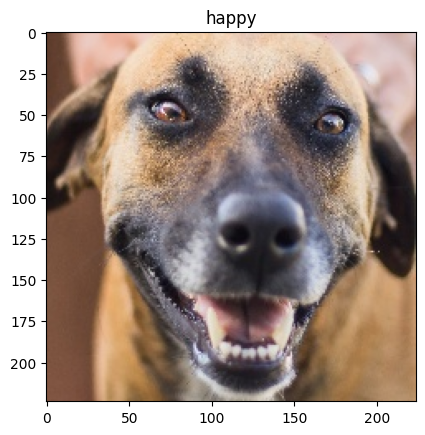

Image in /content/drive/MyDrive/437/archive/Master Folder/train/Other
Target size is : (224, 224), Batch size is : 32


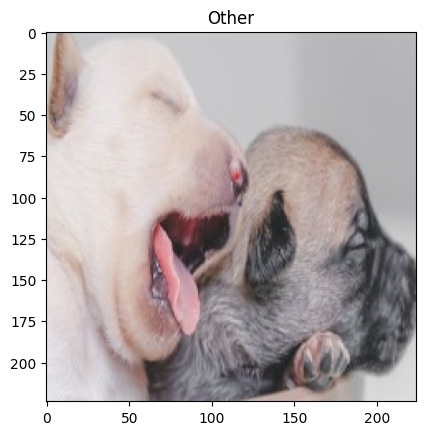

In [ ]:
# Print the first photo of each document and their size.
def processImageSize(directory):
  # Adjust resolution
  target_size = (224, 224)
  batch_size = 32
  print(f"Image in {directory}")
  print(f"Target size is : {target_size}, Batch size is : {batch_size}")

  # Loop all images
  for image_path in os.listdir(directory)[:1]:
    train_image_path = os.path.join(directory, image_path)
    pet_image = mpimg.imread(train_image_path, 0)
    # Display the Image
    plt.imshow(pet_image)
    plt.title(f"{os.path.basename(directory)}")
    plt.show()

# Print for test Angry.
processImageSize(train_AngryData)

# Print for test Sad.
processImageSize(train_SadData)

# Print for test Happy.
processImageSize(train_HappyData)

# Print for test Other.
processImageSize(train_OtherData)

**Create Image Data Generator**

One hot- Image

In [ ]:
# Scale image data from 0-255 to 0-1
datagen = ImageDataGenerator(rescale=1./255)

# load images from a directory and count them
def load_images(data_dir):
  generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',  # Have 4 classes
    shuffle=False
    )
  return generator

# Load images
train_count = load_images(train_data)
valid_count = load_images(valid_data)
test_count = load_images(test_data)

# Counting
train_result = train_count.samples
valid_result = valid_count.samples
test_result = test_count.samples

# Counts are stored in a dictionary, with 0 as the initial value
# Traverse all batches and labels in the training set, find the category index of each label via np.argmax, and update the counts

# Count the number of images in each class in the train set
train_class_counts = dict(zip(train_count.class_indices.keys(), [0]*len(train_count.class_indices)))
for _, label in train_count:
  for l in label:
    class_index = np.argmax(l)
    class_label = list(train_count.class_indices.keys())[class_index]
    train_class_counts[class_label] += 1
  if sum(train_class_counts.values()) >= train_result:
    break

print("Train set:", train_class_counts)

# Count the number of images in each class in the valid set
valid_class_counts = dict(zip(valid_count.class_indices.keys(), [0]*len(valid_count.class_indices)))
for _, label in valid_count:
  for l in label:
    class_index = np.argmax(l)
    class_label = list(valid_count.class_indices.keys())[class_index]
    valid_class_counts[class_label] += 1
  if sum(valid_class_counts.values()) >= valid_result:
    break

print("Valid set:", valid_class_counts)

# Count the number of images in each class in the test set
test_class_counts = dict(zip(test_count.class_indices.keys(), [0]*len(test_count.class_indices)))
for _, label in test_count:
  for l in label:
    class_index = np.argmax(l)
    class_label = list(test_count.class_indices.keys())[class_index]
    test_class_counts[class_label] += 1
  if sum(test_class_counts.values()) >= test_result:
    break

print("Test set:", test_class_counts)

Found 1000 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Train set: {'Angry': 250, 'Other': 250, 'Sad': 250, 'happy': 250}
Valid set: {'Angry': 9, 'Other': 6, 'Sad': 10, 'happy': 11}
Test set: {'Angry': 10, 'Other': 6, 'Sad': 11, 'happy': 11}


Label image

In [ ]:
def get_labels(dataset_dir):
  print("Dataset Path:", dataset_dir)
  # Initializing Variables
  image_paths = []
  img_labels = []
  label_names = sorted(os.listdir(dataset_dir))
  print("Label Names:", label_names)
  label_to_index = {label: idx for idx, label in enumerate(label_names)}
  # Iterate through the directory for each label
  for label in label_names:
    dir_path = os.path.join(dataset_dir, label)
    print("Directory:", dir_path)
    if os.path.isdir(dir_path):
      for file in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file)
        # Check image format
        if os.path.isfile(file_path) and file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
          image_paths.append(file_path)
          img_labels.append(label_to_index[label])
          # Print 4 image paths
          if len(image_paths) <= 4:
            print(file_path)
  return image_paths, img_labels

# Load directory
def get_labels(dataset_dir):
  print("Dataset Path:", dataset_dir)
  image_paths = []
  img_labels = []
  label_names = sorted(os.listdir(dataset_dir))
  print("Label Names:", label_names)
  label_to_index = {label: idx for idx, label in enumerate(label_names)}

  for label in label_names:
    dir_path = os.path.join(dataset_dir, label)
    print("Directory:", dir_path)
    if os.path.isdir(dir_path):
      for file in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file)
        # Check image format
        if os.path.isfile(file_path) and file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
          # Getting image paths and labels
          image_paths.append(file_path)
          img_labels.append(label_to_index[label])
          # Print 4 image paths
          if len(image_paths) <= 4:
            print(file_path)
  return image_paths, img_labels

# Get image paths and labels
train_images, train_labels = get_labels(train_data)
valid_images, valid_labels = get_labels(valid_data)
test_images, test_labels = get_labels(test_data)

Dataset Path: /content/drive/MyDrive/437/archive/Master Folder/train
Label Names: ['Angry', 'Other', 'Sad', 'happy']
Directory: /content/drive/MyDrive/437/archive/Master Folder/train/Angry
/content/drive/MyDrive/437/archive/Master Folder/train/Angry/03.jpg
/content/drive/MyDrive/437/archive/Master Folder/train/Angry/05.jpg
/content/drive/MyDrive/437/archive/Master Folder/train/Angry/02.jpg
/content/drive/MyDrive/437/archive/Master Folder/train/Angry/04.jpg
Directory: /content/drive/MyDrive/437/archive/Master Folder/train/Other
Directory: /content/drive/MyDrive/437/archive/Master Folder/train/Sad
Directory: /content/drive/MyDrive/437/archive/Master Folder/train/happy
Dataset Path: /content/drive/MyDrive/437/archive/Master Folder/valid
Label Names: ['Angry', 'Other', 'Sad', 'happy']
Directory: /content/drive/MyDrive/437/archive/Master Folder/valid/Angry
/content/drive/MyDrive/437/archive/Master Folder/valid/Angry/13.jpg
/content/drive/MyDrive/437/archive/Master Folder/valid/Angry/64.jpg


**Augment training data**

In [ ]:
train_datagen = ImageDataGenerator(
  #Normalize the image
  rescale=1./255,
  # Random rotation angle range
  rotation_range=30,
  # Horizontally
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  # zoom img
  zoom_range=0.2,
  # Flip img
  horizontal_flip=True)

train_dir = '/content/drive/MyDrive/437/archive/Master Folder/train'

new_trainData = train_datagen.flow_from_directory(
  train_dir,
  target_size=(224, 224),
  batch_size=16,
  class_mode='categorical'
)

Found 1000 images belonging to 4 classes.


**Datasets for model validation and testing**

In [ ]:
# Label dataset. TensorFlow label conversion to One-hot
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224]) # Adjust resolution
  # Channel can have values ranging from 0 to 255
  image /= 255.0
  return image

def data_Encode(file_path, label):
  image = load_and_preprocess_image(file_path)
  return image, label

In [ ]:
NUM_CLASSES=4

In [ ]:
# Get one hot for 4 classes
train_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=NUM_CLASSES)
valid_one_hot = tf.keras.utils.to_categorical(valid_labels, num_classes=NUM_CLASSES)
test_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=NUM_CLASSES)

# Created through the tf.data.Dataset.from_tensor_slices function. This function accepts arrays and labels.
tf_train_data = tf.data.Dataset.from_tensor_slices((train_images, train_one_hot))
tf_train_data = tf_train_data.map(data_Encode).batch(16)

tf_valid_data = tf.data.Dataset.from_tensor_slices((valid_images, valid_one_hot))
tf_valid_data = tf_valid_data.map(data_Encode).batch(16)

tf_test_data = tf.data.Dataset.from_tensor_slices((test_images, test_one_hot))
tf_test_data = tf_test_data.map(data_Encode).batch(16)

**Build Model**

In [ ]:
# model = Sequential([
#     # Separable convolutional layers
#     SeparableConv2D(128, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
#     MaxPooling2D((2, 2)),

#     SeparableConv2D(128, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D((2, 2)),

#     SeparableConv2D(256, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D((2, 2)),

#     Flatten(),

#     Dense(512, activation='relu'),
#     # Dropout(0.5),
#     Dense(NUM_CLASSES, activation='softmax')
# ])

In [ ]:
IMG_SHAPE = (224, 224, 3)
# Set the learning rate to 0.001
LEARNING_RATE = 0.001
# DROPOUT_RATE = 0.5
# Sequential model
model = Sequential()

# Base Model
# The base model uses EfficientNetB2, not contain a top layer, not use pooling
base = EfficientNetB2(include_top=False, weights='imagenet', input_shape=IMG_SHAPE, pooling=None)
base.trainable = False
model.add(base)

# Add SeparableConv2D layers
model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same')) # 128 3x3 convolutional kernels
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(SeparableConv2D(256, (3, 3), activation='relu', padding='same')) # 256 3x3 convolutional kernels
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Flatten
model.add(Flatten())
# Dense layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(DROPOUT_RATE))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
# Print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 separable_conv2d_6 (Separa  (None, 7, 7, 128)         193024    
 bleConv2D)                                                      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 3, 3, 128)         0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Ba  (None, 3, 3, 128)         512       
 tchNormalization)                                               
                                                                 
 separable_conv2d_7 (Separa  (None, 3, 3, 256)        

In [ ]:
# # Adam optimizer
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train model
history = model.fit(
    new_trainData,
    steps_per_epoch=new_trainData.samples // new_trainData.batch_size,
    epochs=20,
    validation_data=tf_valid_data,
)

Epoch 1/20
62/62 [==============================] - 133s 2s/step - loss: 1.6314 - accuracy: 0.2287 - val_loss: 1.4068 - val_accuracy: 0.3056
Epoch 2/20
62/62 [==============================] - 111s 2s/step - loss: 1.4585 - accuracy: 0.2642 - val_loss: 1.4196 - val_accuracy: 0.3056
Epoch 3/20
62/62 [==============================] - 114s 2s/step - loss: 1.4451 - accuracy: 0.2470 - val_loss: 1.3882 - val_accuracy: 0.2500
Epoch 4/20
62/62 [==============================] - 115s 2s/step - loss: 1.4336 - accuracy: 0.2632 - val_loss: 1.3645 - val_accuracy: 0.3056
Epoch 5/20
62/62 [==============================] - 111s 2s/step - loss: 1.4288 - accuracy: 0.2520 - val_loss: 1.3788 - val_accuracy: 0.3056
Epoch 6/20
62/62 [==============================] - 114s 2s/step - loss: 1.4269 - accuracy: 0.2541 - val_loss: 1.4166 - val_accuracy: 0.3056
Epoch 7/20
62/62 [==============================] - 110s 2s/step - loss: 1.4150 - accuracy: 0.2683 - val_loss: 1.3977 - val_accuracy: 0.2500
Epoch 8/20
62

In [ ]:
# model_check_point = ModelCheckpoint(
#     filepath='/content/pet_model.h5',
#     monitor='val_accuracy',
#     save_best_only=True,
#     verbose=1
# )

**Test**

In [ ]:
model.save('pet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = load_model('pet_model.h5')
test_loss, test_accuracy = model.evaluate(tf_test_data)

3/3 [==============================] - 8s 1s/step - loss: 1.3931 - accuracy: 0.2632


**Use your image**

In [ ]:
for class_index in range(NUM_CLASSES):
    label = np.array([class_index])

    one_hot = tf.keras.utils.to_categorical(train_labels, NUM_CLASSES)

    print(f"Class Index: {class_index}, One-Hot: {one_hot}")

Class Index: 0, One-Hot: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
Class Index: 1, One-Hot: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
Class Index: 2, One-Hot: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
Class Index: 3, One-Hot: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [ ]:
def prediction(image_path, target_size=(224, 224)):
  # Read and preprocess the image
  # Convert the image to a numpy array
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, target_size)
  image = image / 255.0
  image = np.expand_dims(image, axis=0)
  return image

# Process youself image for prediction
model = load_model('pet_model.h5')
image_path = '/content/drive/MyDrive/437/archive/mycat.JPG'
result = prediction(image_path)

1/1 [==============================] - 3s 3s/step


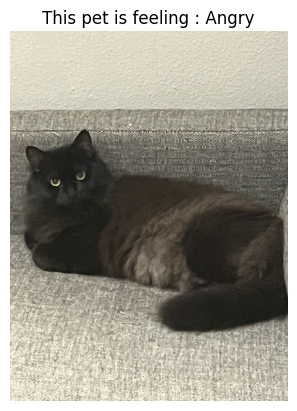

In [ ]:
result_name = ["Angry", "Other", "Sad", "Happy"]

prediction = model.predict(result)
predicted_index = np.argmax(prediction, axis=1)[0]
predicted_class_name = result_name[predicted_index]

# Print the result
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.title(f"This pet is feeling : {predicted_class_name}")
plt.axis('off')
plt.show()